In [1]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from torch import nn,optim,save
import torch

from datetime import datetime, timedelta

from sklearn.linear_model import LinearRegression

import pickle

In [2]:
# dati clinici:
clinical_raw = pd.read_csv("ClinicalData.csv").set_index("Case ID")

radiomic_raw = pd.read_csv("radiomic_features.csv", index_col=0)
radiomic_train_means = pd.read_csv("radiomic_train_means.csv",index_col=0,header=0)

# RNA_seq normalizzati:
RNA_seq = pd.read_csv("RNAseq_norm.csv",index_col=0)

In [3]:
radiomic_train_means

,0
original_shape_Elongation,0.789152
original_shape_Flatness,0.610831
original_shape_LeastAxisLength,22.009642
original_shape_MajorAxisLength,37.046151
original_shape_Maximum2DDiameterColumn,43.356594
...,...
original_gldm_LargeDependenceLowGrayLevelEmphasis,0.408202
original_gldm_LowGrayLevelEmphasis,0.015721
original_gldm_SmallDependenceEmphasis,0.390765
original_gldm_SmallDependenceHighGrayLevelEmphasis,331.255775


In [4]:
#filter low variance RNAs

RNA_low_variance_mask = RNA_seq.T.var() > RNA_seq.T.var().quantile(0.05)

RNA_filtered = RNA_seq[RNA_low_variance_mask]

print(RNA_filtered.shape)

(5004, 130)


In [5]:
# mi recupero il train-test-split che ho fatto sul dataset delle CT
with open('split_dictionary.pkl', 'rb') as f:
    split_dict = pickle.load(f)

train_set = [x[:-7] for x in split_dict["train"]]
val_set = [x[:-7] for x in split_dict["val"]]
test_set = [x[:-7] for x in split_dict["test"]]

all_set = train_set+val_set+test_set

In [6]:
#aggiungo al dataset dei dati clinici una colonna che indica il numero di giorni che il paziente è sopravvissuto dal giorno della CT

def cambia_date(x):
    return datetime.strptime(x,"%m/%d/%Y")

survival_list = list()
clinical_temp = clinical_raw.copy()

for sample in clinical_raw.iterrows():

    date_last = cambia_date(sample[1]["Date of Last Known Alive"])
    date_CT = cambia_date(sample[1]["CT Date"])
    days_CT_surgery = timedelta(days=sample[1]["Days between CT and surgery"])

    if date_last - date_CT > days_CT_surgery: # caso in cui hanno fatto surgery dopo della CT
        delta = date_last - date_CT - days_CT_surgery
    else: # caso in cui hanno fatto surgery prima della CT
        delta = date_last - date_CT + days_CT_surgery

    survival_list.append(delta.days)

clinical_temp["Days Survived"] = survival_list


In [7]:

from collections import Counter
print(Counter(clinical_temp['Pathological T stage']))
print(Counter(clinical_temp['Pathological N stage']))
print(Counter(clinical_temp['Pathological M stage']))

Counter({'Not Collected': 49, 'T2a': 47, 'T1a': 40, 'T1b': 31, 'T3': 21, 'T2b': 10, 'T4': 7, 'Tis': 6})
Counter({'N0': 129, 'Not Collected': 49, 'N2': 18, 'N1': 15})
Counter({'M0': 157, 'Not Collected': 49, 'M1b': 4, 'M1a': 1})


In [8]:
#Rimuovo samples con alcuni dati "Not Collected" e metto Pack Years == 0 per i non fumatori 
clinical_data = clinical_temp[clinical_temp["Pack Years"] != "Not Collected"]
clinical_data = clinical_data[clinical_data["Pathological T stage"] != "Not Collected"]
clinical_data = clinical_data[clinical_data["Pathological N stage"] != "Not Collected"]
clinical_data = clinical_data[clinical_data["Pathological M stage"] != "Not Collected"]
clinical_data = clinical_data[clinical_data["Weight (lbs)"] != "Not Collected"]
clinical_data = clinical_data[clinical_data["Chemotherapy"] != "Not Collected"]
clinical_data = clinical_data[clinical_data["Radiation"] != "Not Collected"]
clinical_data = clinical_data[clinical_data["Recurrence"] != "Not Collected"]
clinical_data["Pack Years"] = clinical_data["Pack Years"].fillna(0)

clinical_data

,Patient affiliation,Age at Histological Diagnosis,Weight (lbs),Gender,Ethnicity,Smoking status,Pack Years,Quit Smoking Year,%GG,Tumor Location (choice=RUL),...,Recurrence Location,Date of Recurrence,Date of Last Known Alive,Survival Status,Date of Death,Time to Death (days),CT Date,Days between CT and surgery,PET Date,Days Survived
Case ID,,,,,,,,,,,,,,,,,,,,,
R01-001,Stanford,79,146,Female,Caucasian,Former,37,1967.0,0%,Checked,...,NaN,NaN,2/9/1999,Alive,NaN,NaN,9/6/1990,42,10/17/1990,3036
R01-002,Stanford,65,195,Female,Asian,Nonsmoker,0,NaN,0%,Checked,...,NaN,NaN,11/29/1990,Alive,NaN,NaN,9/20/1990,23,10/11/1990,47
R01-005,Stanford,84,145,Male,Native Hawaiian/Pacific Islander,Former,20,1951.0,0%,Unchecked,...,distant,1/19/1993,6/3/1995,Dead,6/3/1995,1456.0,3/8/1991,92,4/19/1991,1456
R01-008,Stanford,73,102,Male,Caucasian,Nonsmoker,0,NaN,>0 - 25%,Checked,...,NaN,NaN,8/8/1997,Alive,NaN,NaN,4/24/1991,34,5/11/1991,2264
R01-009,VA,59,133,Male,Caucasian,Current,100,NaN,0%,Unchecked,...,NaN,NaN,9/28/1994,Dead,9/28/1994,1344.0,11/25/1990,59,12/8/1990,1344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R01-158,Stanford,67,143,Male,Hispanic/Latino,Current,25,NaN,Not Assessed,Checked,...,NaN,NaN,9/30/1995,Alive,NaN,NaN,10/6/1994,5,8/19/1994,354
R01-159,Stanford,75,184,Male,Caucasian,Former,55,1994.0,Not Assessed,Unchecked,...,NaN,NaN,7/13/1995,Alive,NaN,NaN,11/24/1994,14,11/16/1994,217
R01-160,VA,61,231.5,Male,Caucasian,Former,12,1993.0,Not Assessed,Checked,...,NaN,NaN,7/3/1999,Alive,NaN,NaN,8/12/1993,72,9/22/1993,2079


In [9]:
# rifaccio la stessa cosa ma senza il dato CD8, per vedere se migliora o peggiora le previsioni

clinical_dummy = pd.get_dummies(clinical_data[["Age at Histological Diagnosis","Weight (lbs)","Gender","Smoking status","Pack Years","Chemotherapy","Radiation","Recurrence","Survival Status","Days Survived", "Pathological T stage", "Pathological N stage", "Pathological M stage"]], columns=["Smoking status", "Pathological T stage", "Pathological N stage", "Pathological M stage"])
#clinical_dummy = clinical_data[["Age at Histological Diagnosis","Weight (lbs)","Gender","Smoking status","Pack Years","Chemotherapy","Radiation","Recurrence","Survival Status","Days Survived", "Pathological T stage", "Pathological N stage", "Pathological M stage"]]

for x in ["Gender", "Survival Status","Chemotherapy","Radiation","Recurrence"]:
    factorized = pd.factorize(clinical_dummy[x])
    clinical_dummy[x] = factorized[0]
    print(x, factorized[1])

new_train_index = [x for x in train_set if x in clinical_dummy.index and x in RNA_filtered.columns and x in radiomic_raw.index]
new_val_index = [x for x in val_set if x in clinical_dummy.index and x in RNA_filtered.columns and x in radiomic_raw.index]
new_test_index = [x for x in test_set if x in clinical_dummy.index and x in RNA_filtered.columns]

new_all_index = new_train_index + new_val_index + new_test_index


intersection = [x for x in clinical_dummy.index if x not in new_all_index and x in RNA_filtered.columns and x in radiomic_raw.index]

new_clinical_noCT = clinical_dummy.loc[intersection,:]

print(new_clinical_noCT.shape)


new_clinical_train = pd.concat([clinical_dummy.loc[new_train_index,:],new_clinical_noCT]).astype(float)
new_clinical_val = clinical_dummy.loc[new_val_index,:].astype(float)
new_clinical_test = clinical_dummy.loc[new_test_index,:].astype(float)

print(new_clinical_train.shape, new_clinical_val.shape, new_clinical_test.shape)


Gender Index(['Female', 'Male'], dtype='object')
Survival Status Index(['Alive', 'Dead'], dtype='object')
Chemotherapy Index(['No', 'Yes'], dtype='object')
Radiation Index(['No', 'Yes'], dtype='object')
Recurrence Index(['no', 'yes'], dtype='object')
(12, 25)
(76, 25) (14, 25) (16, 25)


In [10]:

radiomic_columns = [x for x in radiomic_raw.columns if x.startswith("diagnostics")==False]
print(len(radiomic_columns))

radiomic_data = radiomic_raw[radiomic_columns]

new_radiomic_train = radiomic_data.loc[new_clinical_train.index,:].astype(float)

new_radiomic_val = radiomic_data.loc[new_clinical_val.index,:].astype(float)
new_radiomic_test = radiomic_data.loc[new_clinical_test.index,:].astype(float)

print(new_radiomic_train.shape, new_radiomic_val.shape, new_radiomic_test.shape)

100
(76, 100) (14, 100) (16, 100)


In [11]:
train_clinical_rad = pd.concat([new_radiomic_train/radiomic_train_means["0"], new_clinical_train],axis=1)
val_clinical_rad = pd.concat([new_radiomic_val/radiomic_train_means["0"], new_clinical_val],axis=1)
test_clinical_rad = pd.concat([new_radiomic_test/radiomic_train_means["0"], new_clinical_test],axis=1)

print(train_clinical_rad.shape,val_clinical_rad.shape, test_clinical_rad.shape)

(76, 125) (14, 125) (16, 125)


In [12]:
#divido in train/val/test rispettando lo split fatto sulle CT
# samples che non hanno CT sono messi nel validation set (perché altrimenti erano troppo pochi)


RNA_train = RNA_filtered.loc[:,new_clinical_train.index.tolist()].astype(float)
RNA_val = RNA_filtered.loc[:,new_clinical_val.index.tolist()].astype(float)
RNA_test = RNA_filtered.loc[:,new_clinical_test.index.tolist()].astype(float)

print(RNA_train.shape, RNA_val.shape, RNA_test.shape)


(5004, 76) (5004, 14) (5004, 16)


In [13]:
# definisco modello lineare fully connected 

class ClinicalModel(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(ClinicalModel, self).__init__()
    

    self.layers = nn.Sequential(nn.Linear(input_dim, hidden_dim, dtype=float),
                          nn.ReLU(inplace=True),
                          nn.Linear(hidden_dim, output_dim, dtype=float)
                          )

  def forward(self, x):

    # forward the input through the layers
    x = self.layers(x)

    return x

In [14]:
class RNAModel(torch.nn.Module):
  def __init__(self, input_dim):
    super(RNAModel, self).__init__()
    

    self.layers = nn.Sequential(nn.Linear(input_dim, input_dim//100, dtype=float), #5268
                           nn.ReLU(inplace=True),
                           nn.Linear(input_dim//100,2, dtype=float)
                           )

  def forward(self, x):

    # forward the input through the layers
    x = self.layers(x)

    return x

In [15]:
# definisco modello lineare fully connected 

class RadiomicModel(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(RadiomicModel, self).__init__()
    

    self.layers = nn.Sequential(nn.Linear(input_dim, hidden_dim, dtype=float),
                          nn.ReLU(inplace=True),
                          nn.Linear(hidden_dim, output_dim,dtype=float)
                          )

  def forward(self, x):

    # forward the input through the layers
    x = self.layers(x)

    return x

In [16]:
class FinalModel(torch.nn.Module):
    def __init__(self, clinical_model, RNA_model) -> None:
        super(FinalModel,self).__init__()

        self.clinical_model = clinical_model
        self.RNA_model = RNA_model
        #self.rad_model = rad_model

        self.layers = nn.Sequential(nn.Linear(125, 125, dtype=float),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(125, 1, dtype=float))
        
    def forward(self, clinical, RNA):

        clinical = self.clinical_model(clinical)

        RNA = self.RNA_model(RNA)

        #rad = self.rad_model(rad)

        x = torch.cat([clinical, RNA],axis=1)

        x = self.layers(x)

        return x

In [18]:
class my_dataset(torch.utils.data.Dataset):
    def __init__(self, split,RNA_train, RNA_val, RNA_test, clinical_train, clinical_val, clinical_test, rad_train, rad_val, rad_test, train_means):
        self.split = split

        self.RNA_train = RNA_train
        self.RNA_val = RNA_val
        self.RNA_test = RNA_test

        self.clinical_train = clinical_train
        self.clinical_val = clinical_val
        self.clinical_test = clinical_test

        self.rad_train = rad_train/train_means["0"]
        self.rad_val = rad_val/train_means["0"]
        self.rad_test = rad_test/train_means["0"]

        self.clinical_train = pd.concat([self.clinical_train, self.rad_train],axis=1)
        self.clinical_val = pd.concat([self.clinical_val, self.rad_val],axis=1)
        self.clinical_test = pd.concat([self.clinical_test, self.rad_test],axis=1)


    def __len__(self):
        if self.split == "train":
            return self.RNA_train.shape[1]
        elif self.split == "val":
            return self.RNA_val.shape[1]
        elif self.split == "test":
            return self.RNA_test.shape[1]
    def __getitem__(self,idx):
        
        if self.split == "train":

            row = self.clinical_train.iloc[idx,:].copy()
            row["Age at Histological Diagnosis"] += int(row["Age at Histological Diagnosis"]*np.random.uniform(-0.1,0.1))
            row["Weight (lbs)"] += int(row["Weight (lbs)"]*np.random.uniform(-0.1,0.1))
            row["Pack Years"] += int(row["Pack Years"]*np.random.uniform(-0.1,0.1))
            row["Days Survived"] += int(row["Days Survived"]*np.random.uniform(-0.01,0.01))
            
            clinical = torch.from_numpy(row.drop(["Survival Status", "Days Survived"]).astype(float).to_numpy())

            #rad = torch.from_numpy(self.rad_train.iloc[idx,:].apply(lambda x: x + x*np.random.uniform(-0.1,0.1)).astype(float).to_numpy())
            #rad = torch.from_numpy(self.rad_train.iloc[idx,:].astype(float).to_numpy())
            
            y = torch.Tensor([row["Days Survived"]]).double()

            survived = torch.Tensor([row["Survival Status"]]) 
            
            #rna = torch.from_numpy(self.RNA_train[RNA_train.columns[idx]].apply(lambda x: x + x*np.random.uniform(-0.001,0.001)).astype(float).to_numpy())
            rna = torch.from_numpy(self.RNA_train[RNA_train.columns[idx]].astype(float).to_numpy())


            return clinical, rna, y, survived
        
        elif self.split == "val":

            row = self.clinical_val.iloc[idx,:].copy()
            
            clinical = torch.from_numpy(row.drop(["Survival Status", "Days Survived"]).astype(float).to_numpy())

            #rad = torch.from_numpy(self.rad_val.iloc[idx,:].astype(float).to_numpy())
            
            y = torch.Tensor([row["Days Survived"]]).double()

            survived = torch.Tensor([row["Survival Status"]]) 
            
            rna = torch.from_numpy(self.RNA_val[RNA_val.columns[idx]].astype(float).to_numpy())

            return clinical, rna, y, survived

        elif self.split == "test":

            row = self.clinical_test.iloc[idx,:].copy()
            
            clinical = torch.from_numpy(row.drop(["Survival Status", "Days Survived"]).astype(float).to_numpy())

            #rad = torch.from_numpy(self.rad_test.iloc[idx,:].astype(float).to_numpy())
            
            y = torch.Tensor([row["Days Survived"]]).double()

            survived = torch.Tensor([row["Survival Status"]]) 
            
            rna = torch.from_numpy(self.RNA_test[RNA_test.columns[idx]].astype(float).to_numpy())

            return clinical, rna, y, survived


In [18]:
dataset = my_dataset("train",
                    RNA_train, RNA_val, RNA_test,
                    new_clinical_train, new_clinical_val, new_clinical_test,
                    new_radiomic_train, new_radiomic_val, new_radiomic_test,
                    radiomic_train_means)

dataloader = torch.utils.data.DataLoader(dataset, batch_size = 19, shuffle=True)

In [19]:

classes = Counter(dataset.clinical_train["Survival Status"])

w_alive = classes[1]/classes[0]
w_dead = classes[0]/classes[1]

print(w_alive, w_dead)

0.4339622641509434 2.3043478260869565


In [20]:
# creo modello, loss function, optimizer

RNA_model = RNAModel(input_dim=RNA_filtered.shape[0])
best_checkpoint = torch.load("RNA_class_epochs/368.pth")
RNA_model.load_state_dict(best_checkpoint["model"])

# rad_model = RadiomicModel(100,100,100)


for param in RNA_model.parameters():
    param.requires_grad = False

clinical_model = ClinicalModel(123,123,123)

#randomize initial weights and bias
for name, layer in clinical_model.named_children():
    for c_name, c_layer in layer.named_children():
        if hasattr(c_layer, "weight") == True:
            nn.init.xavier_uniform_(c_layer.weight)
        if hasattr(c_layer, "bias") == True:
            c_layer.bias.data.fill_(0.)

# for name, layer in rad_model.named_children():
#     for c_name, c_layer in layer.named_children():
#         if hasattr(c_layer, "weight") == True:
#             nn.init.xavier_uniform_(c_layer.weight)
#         if hasattr(c_layer, "bias") == True:
#             c_layer.bias.data.fill_(0.)

final_model = FinalModel(clinical_model, RNA_model)

#my_loss = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([w_other, w_adeno]))
            
my_loss = nn.MSELoss()

my_optim = optim.Adam(final_model.parameters(), lr=1e-3, weight_decay=1e-5)

final_model

FinalModel(
  (clinical_model): ClinicalModel(
    (layers): Sequential(
      (0): Linear(in_features=123, out_features=123, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=123, out_features=123, bias=True)
    )
  )
  (RNA_model): RNAModel(
    (layers): Sequential(
      (0): Linear(in_features=5004, out_features=50, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=50, out_features=2, bias=True)
    )
  )
  (layers): Sequential(
    (0): Linear(in_features=125, out_features=125, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=125, out_features=1, bias=True)
  )
)

In [21]:
# per ogni epoca:
#     per ogni sample nel training set:
#         azzera gradienti dell'optimizer
#         metti un po' di noise nei dati
#         dividi dati del sample in input e target
#         ottieni output dal modello
#         se sample è vivo e output > target:
#             se output > 5 anni:
#                 calcola loss tra output e [5 anni]
#             else:
#                 non calcolare la loss, passa al prossimo sample senza fare back-propagation
#         else:
#             calcola loss tra output e target
#         back-propagation
#         optimizer.step()
#     ripeti sul validation set, ma senza fare back-propagation
#     salva il modello

train_losses = []
val_losses = []


for epoch in range(1000):

    if epoch % 100 == 0:
        print(f"\nstarting epoch {epoch}")

    epoch_train_loss = []

    final_model.train()

    dataset.split = "train"

    for batch_idx, (clinical, rna, y_train, survived_train) in enumerate(dataloader):
        
        my_optim.zero_grad()

        output = final_model(clinical,rna)

        survived_train = torch.squeeze(survived_train)

        for i in range(output.shape[0]):
            if output[i,0].item() > y_train[i,0].item() and survived_train[i] == 0:
                if output[i,0].item() > y_train[i,0].item() + 3652:
                    y_train[i,0] = y_train[i,0].item() + 3652
                else:
                    y_train[i,0] = output[i,0].item()
        
        sample_loss = my_loss(y_train, output)

        sample_loss.backward()
        my_optim.step()

        epoch_train_loss.append(sample_loss.item())

    mean_train_loss = pd.Series(epoch_train_loss).mean()

    if epoch % 100 == 0:
        print(f"train loss: {mean_train_loss}")
    train_losses.append(mean_train_loss)

    epoch_val_loss = []

    final_model.eval()

    dataset.split = "val"

    for batch_idx, (clinical, rna, y_val, survived_val) in enumerate(dataloader):

        output = final_model(clinical,rna)

        for i in range(output.shape[0]):
            if output[i,0].item() > y_val[i,0].item() and survived_val[i] == 0:
                if output[i,0].item() > y_val[i,0].item() + 3652:
                    y_val[i,0] = y_val[i,0].item() + 3652
                else:
                    y_val[i,0] = output[i,0].item()
        
        sample_loss = my_loss(y_val, output)
    
        epoch_val_loss.append(sample_loss.item())

    mean_val_loss = pd.Series(epoch_val_loss).mean()

    if epoch % 100 == 0:
        print(f"val loss: {mean_val_loss}")
        print(f"output example: {output[0].item()}, target example: {y_val[0].item()}, status example: {survived_val[0]}")


    val_losses.append(mean_val_loss)

    if epoch == 0 or mean_val_loss < minor_val_loss:

        minor_val_loss = mean_val_loss

        checkpoint = { 
            'epoch': epoch,
            'model': final_model.state_dict(),
            'optimizer': my_optim.state_dict()}
            # "scheduler": my_scheduler}

        save(checkpoint,f"clinical_radiomic_RNA_epochs/{epoch}.pth")

print("finished!")   


starting epoch 0


train loss: 2214958.3865732746
val loss: 2797598.1815883666
output example: 27.004625465519403, target example: 2117.0, status example: tensor([0.])

starting epoch 100
train loss: 273443.08697410603
val loss: 1207377.6880825388
output example: 800.3869289751117, target example: 3059.0, status example: tensor([0.])

starting epoch 200
train loss: 96017.50913488143
val loss: 614566.8925451112
output example: 1232.4846939528354, target example: 225.0, status example: tensor([1.])

starting epoch 300
train loss: 41656.94886921909
val loss: 576505.3043549003
output example: 2198.27734567222, target example: 2198.27734567222, status example: tensor([0.])

starting epoch 400
train loss: 17111.10583226531
val loss: 571714.7547661501
output example: 1591.129956326886, target example: 1425.0, status example: tensor([1.])

starting epoch 500
train loss: 12892.567205947971
val loss: 607853.5055603615
output example: 1732.096247387323, target example: 28.0, status example: tensor([1.])

starting e

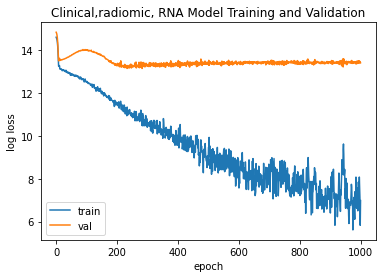

In [25]:
# plot di epoch vs loss su train(blu) e val(arancio)

plt.plot(np.log(train_losses))
plt.plot(np.log(val_losses))
plt.legend(["train", "val"])
plt.title("Clinical,radiomic, RNA Model Training and Validation")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.show()

In [26]:
val_series = pd.Series(val_losses, dtype=float)

print(f"epoch with lowest val loss: {val_series.argmin()}")
print(f"train loss of said epoch: {train_losses[val_series.argmin()]}")
print(f"val loss of said epoch: {val_losses[val_series.argmin()]}")

epoch with lowest val loss: 282
train loss of said epoch: 35798.03079199535
val loss of said epoch: 515516.3555788383


In [17]:
best_checkpoint = torch.load("clinical_radiomic_RNA_epochs/282.pth")


RNA_model = RNAModel(input_dim=RNA_filtered.shape[0])
RNA_checkpoint = torch.load("RNA_class_epochs/368.pth")
RNA_model.load_state_dict(RNA_checkpoint["model"])

for param in RNA_model.parameters():
    param.requires_grad = False

clinical_model = ClinicalModel(123,123,123)

final_model = FinalModel(clinical_model, RNA_model)

final_model.load_state_dict(best_checkpoint["model"])

final_model.eval()

FinalModel(
  (clinical_model): ClinicalModel(
    (layers): Sequential(
      (0): Linear(in_features=123, out_features=123, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=123, out_features=123, bias=True)
    )
  )
  (RNA_model): RNAModel(
    (layers): Sequential(
      (0): Linear(in_features=5004, out_features=50, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=50, out_features=2, bias=True)
    )
  )
  (layers): Sequential(
    (0): Linear(in_features=125, out_features=125, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=125, out_features=1, bias=True)
  )
)

In [19]:
train_expected = []
train_predicted = []
train_survived = []

val_expected = []
val_predicted = []
val_survived = []

test_expected = []
test_predicted = []
test_survived = []

dataset = my_dataset("train",
                    RNA_train, RNA_val, RNA_test,
                    new_clinical_train, new_clinical_val, new_clinical_test,
                    new_radiomic_train, new_radiomic_val, new_radiomic_test,
                    radiomic_train_means)

dataloader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle=True)



for batch_idx, (clinical, rna, y_train, survived_train) in enumerate(dataloader):
    
    output = final_model(clinical,rna)

    train_expected.append(y_train.item())
    train_predicted.append(output.item())
    train_survived.append(survived_train.item())

dataset.split = "val"

for batch_idx, (clinical,rna, y_val, survived_val) in enumerate(dataloader):
    
    output = final_model(clinical,rna)

    val_expected.append(y_val.item())
    val_predicted.append(output.item())
    val_survived.append(survived_val.item())

dataset.split = "test"

for batch_idx, (clinical,rna, y_test, survived_test) in enumerate(dataloader):
    
    output = final_model(clinical,rna)

    test_expected.append(y_test.item())
    test_predicted.append(output.item())
    test_survived.append(survived_test.item())


In [20]:
train_regressor = LinearRegression()

train_regressor.fit(X = np.array(train_expected).reshape(-1,1), y= np.array(train_predicted).reshape(-1,1))

train_y = train_regressor.predict(np.arange(4500).reshape(-1,1))

val_regressor = LinearRegression()

val_regressor.fit(X = np.array(val_expected).reshape(-1,1), y= np.array(val_predicted).reshape(-1,1))

val_y = val_regressor.predict(np.arange(4500).reshape(-1,1))

test_regressor = LinearRegression()

test_regressor.fit(X = np.array(test_expected).reshape(-1,1), y= np.array(test_predicted).reshape(-1,1))

test_y = test_regressor.predict(np.arange(4500).reshape(-1,1))

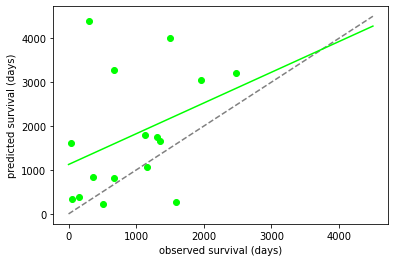

In [25]:
#blue: train
#red: val

# plt.scatter(train_expected, train_predicted, c="blue")
# plt.scatter(val_expected, val_predicted, c="red")
plt.scatter(test_expected, test_predicted, c="lime")

mae = nn.L1Loss()

mse = nn.MSELoss()

# l1_train_loss = mae(torch.Tensor(train_expected), torch.Tensor(train_predicted))
# l1_val_loss = mae(torch.Tensor(val_expected), torch.Tensor(val_predicted))
l1_test_loss = mae(torch.Tensor(test_expected), torch.Tensor(test_predicted))

# mse_train_loss = mse(torch.Tensor(train_expected), torch.Tensor(train_predicted))
# mse_val_loss = mse(torch.Tensor(val_expected), torch.Tensor(val_predicted))
mse_test_loss = mse(torch.Tensor(test_expected), torch.Tensor(test_predicted))

plt.plot(range(4500), range(4500), "--", c = "gray")
# plt.plot(range(3500), train_y, c="blue")
# plt.plot(range(3500), val_y, c="red")
plt.plot(range(4500), test_y, c="lime")

plt.xlabel("observed survival (days)")
plt.ylabel("predicted survival (days)")

#plt.legend(["train","val"])
#plt.legend(["test"])
plt.savefig("no_ct_results.png", dpi=300)

In [22]:
# print(train_regressor.coef_)
# print(train_regressor.intercept_)

# print(val_regressor.coef_)
# print(val_regressor.intercept_)

print(test_regressor.coef_)
print(test_regressor.intercept_)

print("")
# print(l1_train_loss, np.sqrt(mse_train_loss))
# print(l1_val_loss, np.sqrt(mse_val_loss))
print(l1_test_loss, np.sqrt(mse_test_loss))

[[0.70006008]]
[1124.96262601]

tensor(1053.6030) tensor(1517.5043)


In [35]:
from sksurv.metrics import concordance_index_censored

event_indicator = [x==1 for x in train_survived]
last_time = np.array(train_expected)

estimate = 1/np.array(train_predicted)
print(concordance_index_censored(event_indicator, last_time, estimate))

(0.9466437177280551, 1100, 62, 0, 1)


In [36]:
from sksurv.metrics import concordance_index_censored

event_indicator = [x==1 for x in val_survived]
last_time = np.array(val_expected)

estimate = 1/np.array(val_predicted)
print(concordance_index_censored(event_indicator, last_time, estimate))

(0.7213114754098361, 44, 17, 0, 0)
